# Summary
Goal (WIP):
This notebook loads the M5 dataset and creates ARIMA models on aggregated data. Then, TBD model(s) generate product-level models from the ARIMA forecasts.

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from m5_utils import m5_evaluation
import statsmodels.api as sm

# Load Data
This borrows from `load_m5_dataset.ipynb`.

Data details from the original M5 project: https://mofc.unic.ac.cy/wp-content/uploads/2020/03/M5-Competitors-Guide-Final-10-March-2020.docx

## File 1: “calendar.csv” 
Contains information about the dates the products are sold.
* date: The date in a “y-m-d” format.
* wm_yr_wk: The id of the week the date belongs to.
weekday: The type of the day (Saturday, Sunday, …, Friday).
* **wday**: The id of the weekday, starting from Saturday.
* **month**: The month of the date.
* **year**: The year of the date.
* **event_name_1**: If the date includes an event, the name of this event.
* **event_type_1**: If the date includes an event, the type of this event.
* **event_name_2**: If the date includes a second event, the name of this event.
* **event_type_2**: If the date includes a second event, the type of this event.
* **snap_CA, snap_TX, and snap_WI**: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP[1] purchases on the examined date. 1 indicates that SNAP purchases are allowed.

## File 2: “sell_prices.csv”
Contains information about the price of the products sold per store and date.
* **store_id**: The id of the store where the product is sold. 
* **item_id**: The id of the product.
* **wm_yr_wk**: The id of the week.
* **sell_price**: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).

## File 3: “sales_train.csv” 
Contains the historical daily unit sales data per product and store.
* **item_id**: The id of the product.
* **dept_id**: The id of the department the product belongs to.
* **cat_id**: The id of the category the product belongs to.
* **store_id**: The id of the store where the product is sold.
* **state_id**: The State where the store is located.
* **d_1, d_2, …, d_i, … d_1941**: The number of units sold at day i, starting from 2011-01-29. 

**Footnotes**

[1] The United States federal government provides a nutrition assistance benefit called the Supplement Nutrition Assistance Program (SNAP).  SNAP provides low income families and individuals with an Electronic Benefits Transfer debit card to purchase food products.  In many states, the monetary benefits are dispersed to people across 10 days of the month and on each of these days 1/10 of the people will receive the benefit on their card.  More information about the SNAP program can be found here: https://www.fns.usda.gov/snap/supplemental-nutrition-assistance-program 

In [2]:
m5_input_path = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy"
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
sell_price = pd.read_csv(f'{m5_input_path}/sell_prices.csv')
sales_train_eval = pd.read_csv(f'{m5_input_path}/sales_train_evaluation.csv').set_index('id')
sample_sub = pd.read_csv(f'{m5_input_path}/sample_submission.csv')

In [3]:
# Get column groups
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in sales_train_eval.columns if col not in cat_cols]
ts_dict = {t: int(t[2:]) for t in ts_cols}

In [4]:
sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60980 entries, 0 to 60979
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60980 non-null  object
 1   F1      60980 non-null  int64 
 2   F2      60980 non-null  int64 
 3   F3      60980 non-null  int64 
 4   F4      60980 non-null  int64 
 5   F5      60980 non-null  int64 
 6   F6      60980 non-null  int64 
 7   F7      60980 non-null  int64 
 8   F8      60980 non-null  int64 
 9   F9      60980 non-null  int64 
 10  F10     60980 non-null  int64 
 11  F11     60980 non-null  int64 
 12  F12     60980 non-null  int64 
 13  F13     60980 non-null  int64 
 14  F14     60980 non-null  int64 
 15  F15     60980 non-null  int64 
 16  F16     60980 non-null  int64 
 17  F17     60980 non-null  int64 
 18  F18     60980 non-null  int64 
 19  F19     60980 non-null  int64 
 20  F20     60980 non-null  int64 
 21  F21     60980 non-null  int64 
 22  F22     60980 non-null

In [5]:
sample_sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
sales_train_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30490 entries, HOBBIES_1_001_CA_1_evaluation to FOODS_3_827_WI_3_evaluation
Columns: 1946 entries, item_id to d_1941
dtypes: int64(1941), object(5)
memory usage: 452.9+ MB


In [7]:
sales_train_eval.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


# Tests

## Fraction of Observations that are Zeros

In [8]:
test_zeros = (
    sales_train_eval
    .drop(cat_cols, axis=1)
    .isin([0])
    .sum(axis=0)
    .transpose()
)

In [9]:
df_test_zeros = test_zeros.to_frame(name='zeros')
df_test_zeros['frac_zero'] = df_test_zeros.zeros / len(sales_train_eval)
print(df_test_zeros)

        zeros  frac_zero
d_1     23511   0.771105
d_2     23610   0.774352
d_3     24500   0.803542
d_4     24518   0.804133
d_5     25422   0.833782
...       ...        ...
d_1937  17561   0.575959
d_1938  17473   0.573073
d_1939  16616   0.544966
d_1940  15235   0.499672
d_1941  14806   0.485602

[1941 rows x 2 columns]


<AxesSubplot:>

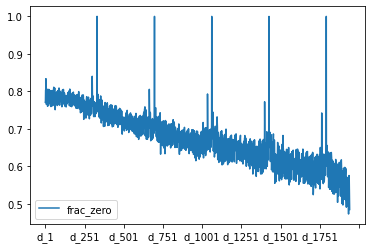

In [10]:
df_test_zeros.plot(y='frac_zero')

# Build Aggregated Dataset
This borrows from the provided `load_m5_dataset.ipynb` notebook

In [11]:
# Describe data
print('  unique forecasts: %i' % sales_train_eval.shape[0])
for col in cat_cols:
    print('   N_unique %s: %i' % (col, sales_train_eval[col].nunique()))

  unique forecasts: 30490
   N_unique item_id: 3049
   N_unique dept_id: 7
   N_unique cat_id: 3
   N_unique store_id: 10
   N_unique state_id: 3


In [12]:
sales_train_eval.dept_id.unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [13]:
sales_train_eval.cat_id.unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

In [14]:
sales_train_eval.store_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

## Top level across all stores and categories

In [15]:
%%time
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(sales_train_eval[ts_cols].sum()).transpose()
# all_sales = pd.DataFrame(train[ts_cols].sum())
all_sales['id_str'] = 'all'
all_sales = all_sales[ ['id_str'] +  [c for c in all_sales if c not in ['id_str']] ]
all_sales

CPU times: user 183 ms, sys: 215 ms, total: 399 ms
Wall time: 397 ms


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338


## State level

In [16]:
%%time
# 2. All products by state (3 series)
state_sales = sales_train_eval.groupby('state_id',as_index=False)[ts_cols].sum()
state_sales['id_str'] = state_sales['state_id'] 
state_sales = state_sales[ ['id_str'] +  [c for c in state_sales if c not in ['id_str']] ]
state_sales = state_sales.drop(['state_id'],axis=1)
state_sales

CPU times: user 927 ms, sys: 443 ms, total: 1.37 s
Wall time: 1.37 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
1,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
2,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879


## Store level

In [17]:
%%time
# 3. All products by store (10 series)
store_sales = sales_train_eval.groupby('store_id',as_index=False)[ts_cols].sum()
store_sales['id_str'] = store_sales['store_id'] 
store_sales = store_sales[ ['id_str'] +  [c for c in store_sales if c not in ['id_str']] ]
store_sales = store_sales.drop(['store_id'],axis=1)
store_sales

CPU times: user 959 ms, sys: 414 ms, total: 1.37 s
Wall time: 1.37 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
1,CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
2,CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
3,CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
4,TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
5,TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217
6,TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,...,4295,4155,5383,4341,4052,3710,3288,4390,4712,4974
7,WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,...,3978,5527,5488,3505,3323,3242,3478,3813,5002,5054
8,WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,...,5317,7704,7586,5011,4628,4533,4628,4880,5213,5068
9,WI_3,4038,4198,3317,3211,2132,4590,4486,5991,4850,...,3987,5674,5894,3897,3306,3268,3398,4126,4519,4757


## Category level

In [18]:
%%time
# 4. All products by category (3 series)
cat_sales = sales_train_eval.groupby('cat_id',as_index=False)[ts_cols].sum()
cat_sales['id_str'] = cat_sales['cat_id'] 
cat_sales = cat_sales[ ['id_str'] +  [c for c in cat_sales if c not in ['id_str']] ]
cat_sales = cat_sales.drop(['cat_id'],axis=1)
cat_sales

CPU times: user 923 ms, sys: 446 ms, total: 1.37 s
Wall time: 1.36 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS,23178,22758,17174,18878,14603,22093,20490,27751,24862,...,30107,36576,41447,29158,26148,24790,24737,28136,33599,35967
1,HOBBIES,3764,3357,2682,2669,1814,3220,2944,3986,2899,...,3871,4893,5016,3528,3629,3740,3475,4143,5333,5280
2,HOUSEHOLD,5689,5634,3927,3865,2729,3898,4576,6195,4975,...,10095,12839,13458,9676,9000,8566,8751,10273,12586,13091


## Department level

In [19]:
%%time
# 5. All products by department (7 series)
dept_sales = sales_train_eval.groupby('dept_id',as_index=False)[ts_cols].sum()
dept_sales['id_str'] = dept_sales['dept_id'] 
dept_sales = dept_sales[ ['id_str'] +  [c for c in dept_sales if c not in ['id_str']] ]
dept_sales = dept_sales.drop(['dept_id'],axis=1)
dept_sales

CPU times: user 953 ms, sys: 412 ms, total: 1.36 s
Wall time: 1.36 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,...,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
1,FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,...,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
2,FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,...,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
3,HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,...,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
4,HOBBIES_2,154,185,185,138,100,87,89,155,158,...,449,479,552,419,487,449,448,382,501,560
5,HOUSEHOLD_1,4105,3858,2827,2732,1802,2664,3161,4334,3494,...,7936,10042,10572,7609,6999,6641,6759,7974,9668,10165
6,HOUSEHOLD_2,1584,1776,1100,1133,927,1234,1415,1861,1481,...,2159,2797,2886,2067,2001,1925,1992,2299,2918,2926


## Combined dataset

In [20]:
## TOP LEVEL aggregates + TOTAL
df_agg = pd.concat([all_sales,state_sales,store_sales,cat_sales,dept_sales],ignore_index=True)
df_agg = df_agg.set_index('id_str')
df_agg

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
id_str,,,,,,,,,,,,,,,,,,,,,
all,32631,31749,23783,25412,19146,29211,28010,37932,32736,25572,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338
CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,11822,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,7319,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,6431,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624


## Split off the test data

In [21]:
# Drop test columns
test_cols = [f'd_{x}' for x in range(1914, 1942)]
df_agg_train_val = df_agg.drop(test_cols, axis=1)
df_agg_train_val

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id_str,,,,,,,,,,,,,,,,,,,,,
all,32631,31749,23783,25412,19146,29211,28010,37932,32736,25572,...,41789,48362,51640,38059,37570,35343,35033,40517,48962,49795
CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,11822,...,16255,20564,23032,17052,15784,15148,14488,17095,21834,23187
TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,7319,...,10800,12460,13709,9868,10922,9600,9602,10615,12266,12282
WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,6431,...,14734,15338,14899,11139,10864,10595,10943,12807,14862,14326
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,4440,5352,5760,3830,3631,3691,3303,4457,5884,6082
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,5337,6936,8271,6068,5683,5235,5018,5623,7419,7721
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2496,2839,3047,2809,2677,2500,2458,2628,2954,3271
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3084,3724,4192,3410,3257,2901,2776,3022,3700,4033


In [22]:
df_agg_test = df_agg.loc[:, test_cols]
df_agg_test

,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
id_str,,,,,,,,,,,,,,,,,,,,,
all,38793,35487,34445,34732,42896,50429,53032,43181,44314,39601,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338
CA,17524,15012,14836,14664,17180,22327,23689,19117,17830,17266,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
TX,10662,9933,9575,9655,12162,12694,14193,10719,11949,9909,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
WI,10607,10542,10034,10413,13554,15408,15150,13345,14535,12426,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879
CA_1,4472,3703,3715,3618,4573,5898,6397,4794,4594,4234,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
CA_2,3926,3525,3527,3754,4382,6349,6193,4434,3977,4243,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
CA_3,6359,5289,5065,5015,5705,7057,7828,6776,6325,6204,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
CA_4,2767,2495,2529,2277,2520,3023,3271,3113,2934,2585,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
TX_1,3076,2853,2984,2664,3687,4052,4412,2859,3217,2839,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624


# Fit SARIMA Model
References:
1. https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
2. https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

TODO:
1. Do leap years need special treatment?

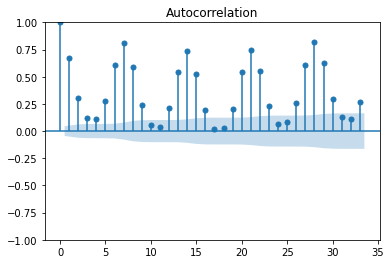

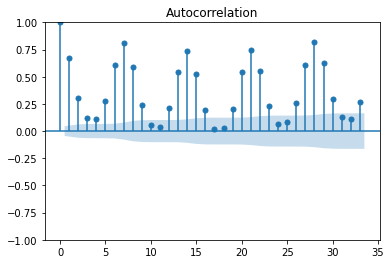

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_agg_train_val.loc['all', :])

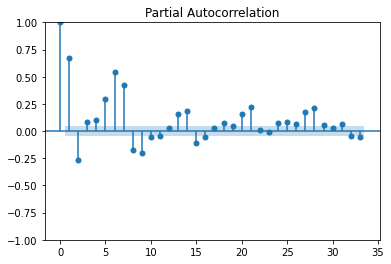

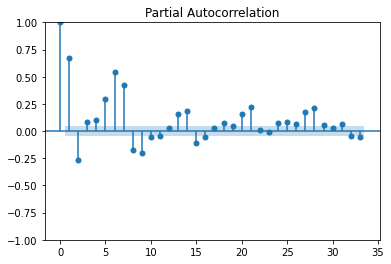

In [24]:
plot_pacf(df_agg_train_val.loc['all', :], method='ywm')

In [25]:
# Starting point: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

# grid search sarima hyperparameters for monthly car sales dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False, model_num=0):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(f'{model_num} > Model[{key}] {result:.3f}')
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True, debug=False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count()//2, backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg, model_num=mi, debug=debug) for mi, cfg in enumerate(cfg_list)]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(p_params = [0, 1, 2],
                   d_params = [0, 1],
                   q_params = [0, 1],
                   t_params = ['c','t','ct'],
                   P_params = [0],
                   D_params = [0],
                   Q_params = [0],
                   seasonal=[0]):
    
    models = list()
    # define config lists
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [30]:
# Choose dataset
data = df_agg_train_val.loc['all', :].values
print(data.shape)

# data split
n_test = 6

# model configs
cfg_list = sarima_configs(p_params=[2, 3], d_params=[1], q_params=[1, 2], t_params=['t'],
                          P_params=[1], D_params=[1], Q_params=[1], seasonal=[0, 7])
# print(cfg_list)
print(len(cfg_list))

# grid search
scores = grid_search(data, cfg_list, n_test, parallel=False)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

(1913,)
8
1 > Model[[(2, 1, 1), (1, 1, 1, 7), 't']] 1322.337
3 > Model[[(2, 1, 2), (1, 1, 1, 7), 't']] 1867.942
5 > Model[[(3, 1, 1), (1, 1, 1, 7), 't']] 1273.610
7 > Model[[(3, 1, 2), (1, 1, 1, 7), 't']] 954.121
done
[(3, 1, 2), (1, 1, 1, 7), 't'] 954.1211146177525
[(3, 1, 1), (1, 1, 1, 7), 't'] 1273.6098007327544
[(2, 1, 1), (1, 1, 1, 7), 't'] 1322.3370942701672


In [45]:
model_sarima = SARIMAX(data, order=(2, 1, 3), seasonal_order=(1, 1, 1, 7), trend='t', 
                       enforce_stationarity=False, enforce_invertibility=False)

In [46]:
fit_sarima = model_sarima.fit(maxiter=100)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52327D+00    |proj g|=  2.51009D-01

At iterate    5    f=  9.51511D+00    |proj g|=  9.70836D-02

At iterate   10    f=  9.48883D+00    |proj g|=  2.36800D-01

At iterate   15    f=  9.48111D+00    |proj g|=  1.04374D-01

At iterate   20    f=  9.47497D+00    |proj g|=  2.58937D-02

At iterate   25    f=  9.47372D+00    |proj g|=  5.49146D-02

At iterate   30    f=  9.47304D+00    |proj g|=  3.25283D-02

At iterate   35    f=  9.47271D+00    |proj g|=  1.72478D-03

At iterate   40    f=  9.47268D+00    |proj g|=  4.58319D-03

At iterate   45    f=  9.47266D+00    |proj g|=  7.92997D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [47]:
print(fit_sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1913
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 7)   Log Likelihood              -18121.204
Date:                             Wed, 16 Mar 2022   AIC                          36260.409
Time:                                     22:12:33   BIC                          36310.327
Sample:                                          0   HQIC                         36278.788
                                            - 1913                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0004      0.006     -0.060      0.952      -0.012       0.011
ar.L1         -1.5652      

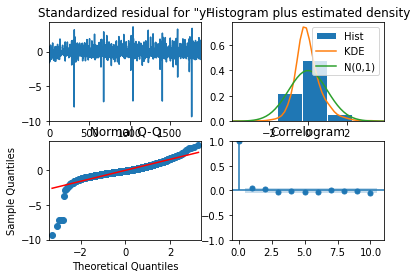

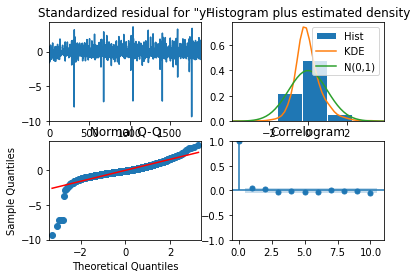

In [58]:
fit_sarima.plot_diagnostics()

In [55]:
Y = fit_sarima.get_prediction()

In [57]:
dir(Y)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_df',
 '_predicted_mean',
 '_row_labels',
 '_use_pandas',
 '_var_pred_mean',
 '_wrap_pandas',
 'conf_int',
 'dist',
 'dist_args',
 'model',
 'predicted_mean',
 'prediction_results',
 'row_labels',
 'se_mean',
 'summary_frame',
 't_test',
 'tvalues',
 'var_pred_mean']

In [108]:
df_agg_test.loc['all'].values

array([38793, 35487, 34445, 34732, 42896, 50429, 53032, 43181, 44314,
       39601, 40763, 43805, 54239, 45609, 46400, 39379, 42248, 40503,
       44073, 54308, 59921, 42362, 38777, 37096, 36963, 42552, 51518,
       54338])

[1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940]
[39073.55476039 36412.04592586 35994.64619554 36213.31749939
 39943.21275917 49288.19842649 49438.45998112 39006.25445313
 36445.27617388 35982.45205361 36426.26049776 39852.82156193
 49367.94990526 49400.41761196 39022.34141834 36463.11597856
 35994.73853003 36468.86915726 39852.98521471 49397.21084553
 49405.50736948 39043.83994477 36474.70448034 36014.27974609
 36483.89282466 39869.61348283 49411.45020136 49421.25491977]


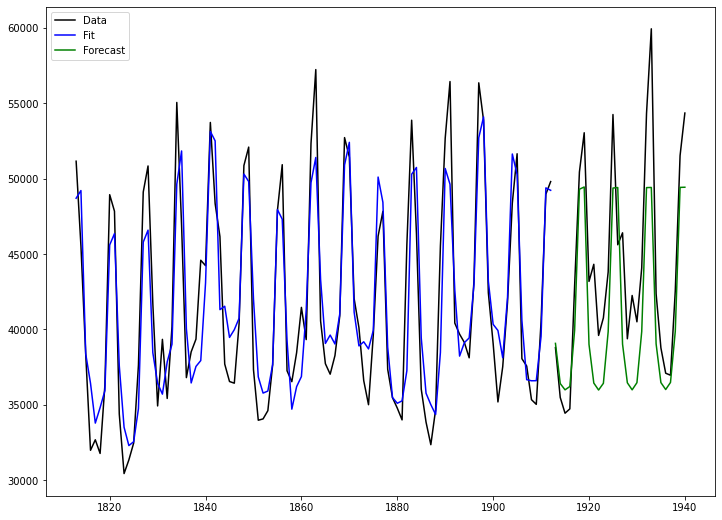

In [110]:
import matplotlib.pyplot as plt

X = range(len(data))
X_oos = [x + len(X) for x in range(28)]
Y_oos = fit_sarima.get_forecast(steps=28).predicted_mean
print(X_oos)
print(Y_oos)


fig, ax = plt.subplots(figsize=(12,9))
ax.plot(X[-100:], data[-100:], 'k-', label='Data')
ax.plot(X[-100:], Y.predicted_mean[-100:], 'b-', label='Fit')
ax.plot(X_oos, df_agg_test.loc['all'].values, 'k-')
ax.plot(X_oos, Y_oos, 'g-', label='Forecast')
ax.legend(loc='best')